In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, auc
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

from math import sqrt
from scipy import stats
from scipy.stats import pearsonr, spearmanr
from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

import env
import wrangle


## I. Acquire Data

In [2]:
# Acquiring the data from the csv file and displaying first 5 rows
df = pd.read_csv('Bank Customer Churn Prediction.csv')

In [3]:
df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## II. Clean & Prepare Data

In [4]:
# Checking the number of rows and columns
df.shape

(10000, 12)

In [5]:
#checking the DataFrame for nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [6]:
#checking the nulls
df.isnull().sum()

customer_id         0
credit_score        0
country             0
gender              0
age                 0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
churn               0
dtype: int64

In [7]:
#checking overall statistics about the dataset
df.describe()

,customer_id,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [8]:
#checking DataFrame columns
df.columns

Index(['customer_id', 'credit_score', 'country', 'gender', 'age', 'tenure',
       'balance', 'products_number', 'credit_card', 'active_member',
       'estimated_salary', 'churn'],
      dtype='object')

In [9]:
#dropping unnecessary columns
df = df.drop(['customer_id'], axis =1)
df.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [10]:
#checking country value count
df.country.value_counts()

France     5014
Germany    2509
Spain      2477
Name: country, dtype: int64

## Data Pre-processing

In [11]:
#encoding categorical column for country 
dummies = pd.get_dummies(df.country,drop_first = False)
df=pd.concat([df,dummies],axis=1)
df.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,France,Germany,Spain
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,0,0
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,0,0,1
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,0,0
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,1,0,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,0,1


In [12]:
#encoding categorical column for gender
dummies = pd.get_dummies(df.gender,drop_first = False)
df=pd.concat([df,dummies],axis=1)
df.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,France,Germany,Spain,Female,Male
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,0,0,1,0
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,0,0,1,1,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,0,0,1,0
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,1,0,0,1,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,0,1,1,0


## Takeaways
- The dataset contains 1000 rows and 12 columns
- The datset has no nulls
- The dataset looks clean with all columns lower case and underscores where necessary
- Dataset had unnecessary column - customer_Id that I dropped not needed for analysis
- I did encode categorical columns country and gender

## Split the data

In [13]:
# this function is splitting data to train, validate, and test to avoid data leakage
def my_train_test_split(df,churn):
    '''
    This function performs split on The bank churn data, stratify churn.
    Returns train, validate, and test dfs.
    '''
    train, test = train_test_split(df, test_size=.2, random_state=123, stratify=df["churn"])
    train, validate = train_test_split(train, test_size=.25, random_state=123, stratify=train["churn"])

    return train, validate, test 

In [14]:
#define data split
train, validate, test = my_train_test_split(df,'churn')

In [15]:
#checking shape of dataset after split
train.shape, validate.shape, test.shape

((6000, 16), (2000, 16), (2000, 16))

In [16]:
#checking statistical data distribution
train.describe()

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,France,Germany,Spain,Female,Male
count,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000
mean,650.377000,38.882333,5.015833,75571.271055,1.527167,0.705667,0.517000,99893.188622,0.203833,0.504500,0.248333,0.247167,0.449333,0.550667
std,96.156254,10.306512,2.891016,62392.724228,0.575602,0.455780,0.499753,57509.678695,0.402880,0.500021,0.432082,0.431400,0.497468,0.497468
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,91.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.000000,0.000000,50895.310000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,651.000000,37.000000,5.000000,96647.175000,1.000000,1.000000,1.000000,99812.150000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
75%,717.250000,44.000000,8.000000,126995.585000,2.000000,1.000000,1.000000,149079.755000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,850.000000,92.000000,10.000000,238387.560000,4.000000,1.000000,1.000000,199992.480000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [17]:
#checking columns for univariate & bivariate analysis
train.head(3)

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,France,Germany,Spain,Female,Male
4053,550,Spain,Male,51,5,0.0,2,1,0,153917.41,0,0,0,1,0,1
9797,627,Spain,Male,40,10,0.0,2,1,1,194792.42,0,0,0,1,0,1
4101,673,Spain,Female,57,4,0.0,2,1,1,49684.09,0,0,0,1,1,0


## III. Exploratory Data Analysis

### Exploratory questions
- What are the key factors that affect customer churn?
- How do these factors affect customer churn?
- Which is the best method to predict customer churn?


## Churn overview

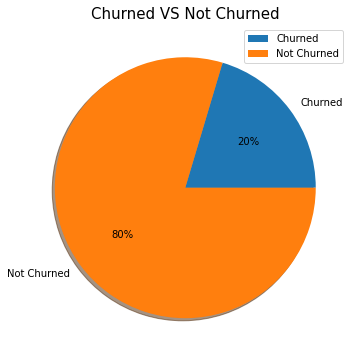

In [18]:
#churn vs not churn pie chart
sizes = [train.churn[train['churn']==1].count(), train.churn[train['churn']==0].count()]
labels = ['Churned', 'Not Churned']
figure, axes = plt.subplots(figsize=(8, 6))
axes.pie(sizes, labels=labels,shadow=True,autopct = '%1.0f%%')
plt.legend()
plt.title("Churned VS Not Churned", size = 15)
plt.show()

## Univariate Analysis
## Categorical Variables

In [19]:
#categorical variables
num_vars = ['churn']
cat_vars = ['country','gender','active_member', 'credit_card', 'products_number','churn'
           ]

country
France     3027
Germany    1490
Spain      1483
Name: country, dtype: int64
France     50.450000
Germany    24.833333
Spain      24.716667
Name: country, dtype: float64


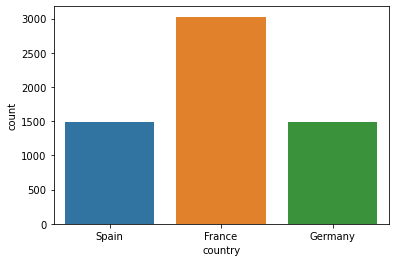

gender
Male      3304
Female    2696
Name: gender, dtype: int64
Male      55.066667
Female    44.933333
Name: gender, dtype: float64


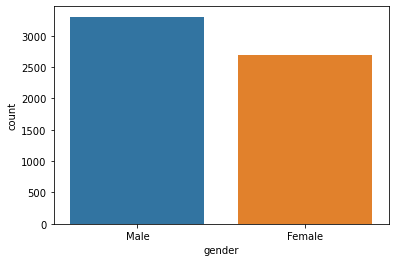

active_member
1    3102
0    2898
Name: active_member, dtype: int64
1    51.7
0    48.3
Name: active_member, dtype: float64


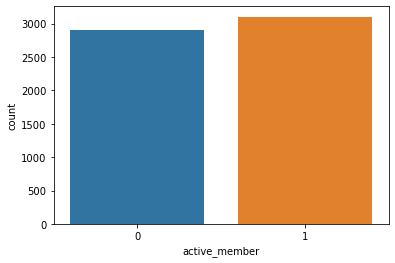

credit_card
1    4234
0    1766
Name: credit_card, dtype: int64
1    70.566667
0    29.433333
Name: credit_card, dtype: float64


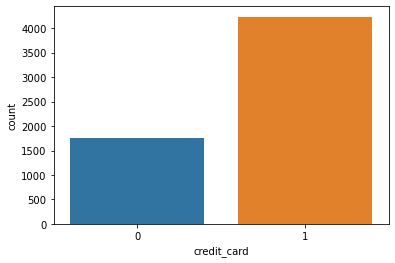

products_number
1    3053
2    2761
3     156
4      30
Name: products_number, dtype: int64
1    50.883333
2    46.016667
3     2.600000
4     0.500000
Name: products_number, dtype: float64


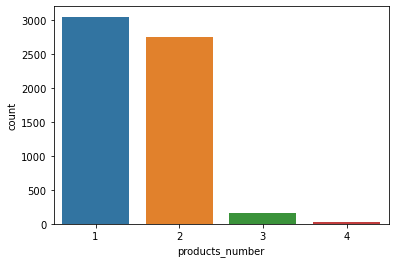

churn
0    4777
1    1223
Name: churn, dtype: int64
0    79.616667
1    20.383333
Name: churn, dtype: float64


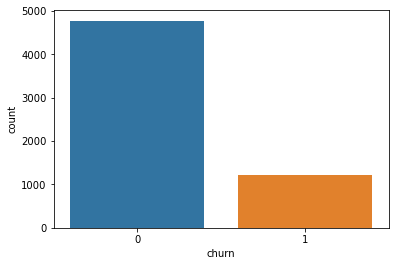

In [20]:
#Analysing categorical variables and their percentages
for col in cat_vars:
    print(col)
    print(train[col].value_counts())
    print(train[col].value_counts(normalize=True)*100)
    sns.countplot(x=col, data=train)
    plt.show()

## Quantitative Variables

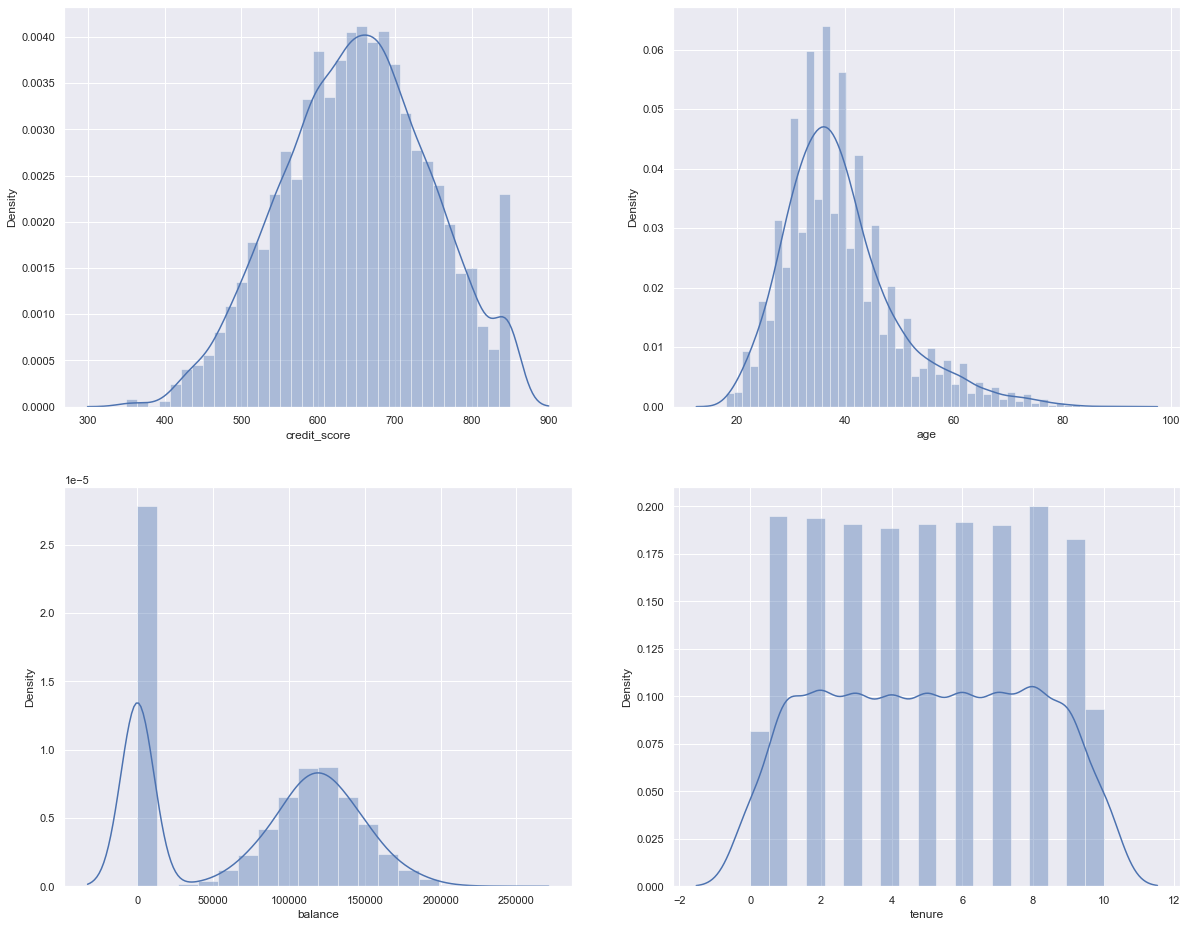

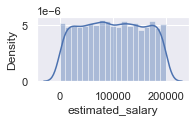

In [21]:
#Analysing quantitative variables using my predefined module stored in the wrangle file
wrangle.plot_quant_vars(train)

## Takeaways:
Looking at our categorical variables:
- We can see that 50% of customers are predominantly from France, and about 25% from Spain and about 25% from Germany
- We can also see that 55% of male customers and 45% female
- We also see 51% active customers while 49% non active members
- we can also verify that most customers 70% have credit card, therefore most transactions are made by credit card
- looking at the variable product_number, we can see that we have more of products 1 and 2 than the rest.
- when we look at our target variable - churn we can see that we have 20% of customers leaving.

Looking at our quantitative variables:
- We can see that our credit score variable has a practically normal distribution
- Credit score observation: most frequency is in 600-700 score range
- A look at the age, most people in our base are between ages 20 and 40 years old
- We can also see on the balance that a large number of people who have no value on the balance sheet
- A look at tenure we can see that it has well distributed values

## Heatmap

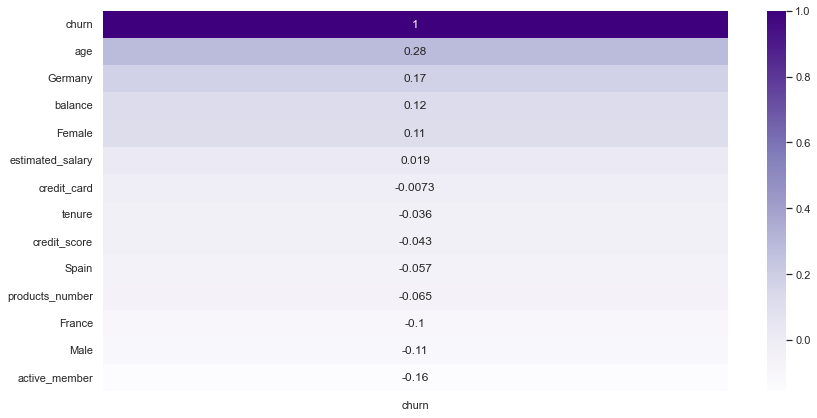

In [22]:
#checking correlation between variables.
correlation = train.corr()[["churn"]].sort_values(by='churn', ascending=False)
plt.figure(figsize = (14,7))
sns.heatmap(correlation, annot = True,cmap='Purples')
plt.show()

## Takeaway

- Here, I analyzed 14 factcors using correlation matrix, which may contribute to the customer churn. The studied factors include credit score, age, tenure, balance, products number, credit card, active member, estimated salary, churn, France, Germany, Spain, Female, Male.

- Result: All the correlation coefficients between the factors and outcome of churn are small. But of all these factors, four factors (age, Germany, balance, Female) show relative strong correlation with the outcome of churn.

## Bivariate Analysis

In [23]:
#categorical & quantitative variables
cat_vars = ['country','gender','active_member', 'credit_card', 'products_number' ]
target = 'churn'
cat_vars2=['country','gender','active_member', 'credit_card', 'products_number']
quant_var = ['credit_score', 'balance', 'estimated_salary', 'age', 'tenure']

## Do these features have a strong relationship with churn?

In [24]:
#Let us analyze categorical variables and their relationship to churn using this function.
def cat_vis(train, col):
    plt.title('Checking if there is a relationship between churn rate and '+col )
    sns.barplot(x=col, y='churn', data=train)
    churn_rate = train.churn.mean()
    plt.axhline(churn_rate, label='churn rate')
    plt.legend()
    plt.show()

def cat_test(train, col):
    alpha = 0.05
    null_hyp = col+' and churn rate are independent'
    alt_hyp = 'There is a relationship between churn rate and '+col
    observed = pd.crosstab(train.churn, train[col])
    chi2, p, degf, expected = stats.chi2_contingency(observed)
    if p < alpha:
        print('We reject the null hypothesis that', null_hyp)
        print(alt_hyp)
    else:
        print('We fail to reject the null hypothesis that', null_hyp)
        print('There appears to be no relationship between churn rate and '+col)

def cat_analysis(train, col):
    cat_vis(train, col)
    cat_test(train, col)

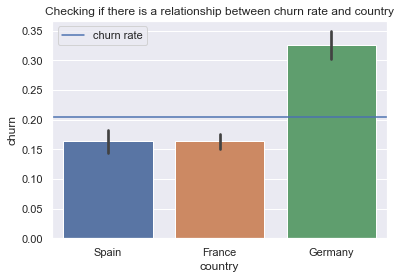

We reject the null hypothesis that country and churn rate are independent
There is a relationship between churn rate and country


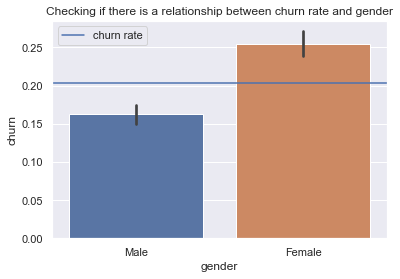

We reject the null hypothesis that gender and churn rate are independent
There is a relationship between churn rate and gender


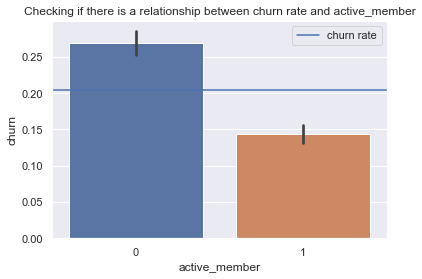

We reject the null hypothesis that active_member and churn rate are independent
There is a relationship between churn rate and active_member


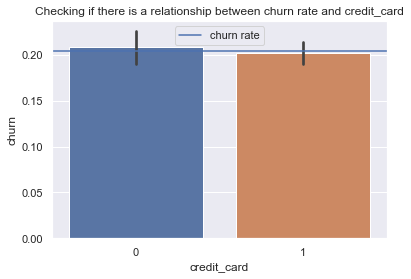

We fail to reject the null hypothesis that credit_card and churn rate are independent
There appears to be no relationship between churn rate and credit_card


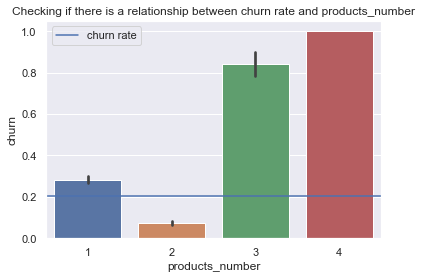

We reject the null hypothesis that products_number and churn rate are independent
There is a relationship between churn rate and products_number


In [25]:

for col in cat_vars:
    cat_analysis(train, col)

## Takeaways
. To address our exploratory questions:

What are the key factors that affect customer churn?

How do these factors affect customer churn?

. As seen from the above plots, we found out that:

- Country: Germany has the highest churn rate compared to other countries Spain and France. This could probably suggest that the Bank has a heavy customer competition in this area. 
- Gender: Female customers are easier to churn than male customers probably because they are high spenders than male.
- Active member: Non active customers have a high churn rate.
- Credit card: There isn't much significance between customers with and without credit card.
- Product number: Bank product numbers 3 and 4 have a high churn rate, this could suggest that they are not doing well in the market.

# IV. Modeling

In [26]:
#X will be features
#y will be our target variable
#these features have high correlation to churn rate
features = ["France","Germany", "Spain", "Male","Female", "balance","age","estimated_salary"]

X_train = train[features]
y_train = train.churn
X_validate = validate[features]
y_validate = validate.churn
X_test = test[features]
y_test = test.churn


In [27]:
X_train.head(2)

,France,Germany,Spain,Male,Female,balance,age,estimated_salary
4053,0,0,1,1,0,0.0,51,153917.41
9797,0,0,1,1,0,0.0,40,194792.42


## Establish a Baseline

In [28]:
#baseline prediction:baseline is the mode value
y_train.value_counts()

0    4777
1    1223
Name: churn, dtype: int64

In [29]:
baseline_accuracy = (y_train == 0).mean()
print('The churn baseline accuracy is:', baseline_accuracy)

The churn baseline accuracy is: 0.7961666666666667


## Model 1: Decision Tree

Accuracy of train: 81.57%
Accuracy of validate: 81.70%


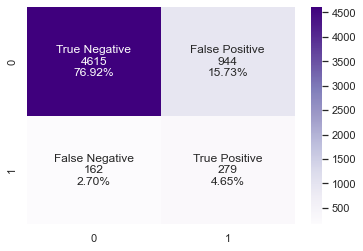

In [30]:
# make the thing
clf = tree.DecisionTreeClassifier(max_depth = 4, random_state = 123)
# fit the thing
clf.fit(X_train, y_train)
# use the thing
pred = clf.predict(X_train)
accuracy_train = clf.score(X_train, y_train)
accuracy_validate = clf.score(X_validate, y_validate)
print("Accuracy of train:", '{:.2%}'.format(accuracy_train))
print("Accuracy of validate:", '{:.2%}'.format(accuracy_validate))
cf_matrix = confusion_matrix(pred, y_train)

group_names = ['True Negative','False Positive','False Negative','True Positive']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot = labels, fmt = '', cmap = 'Purples')
plt.show()

## Model 2: Random Forest

Accuracy of train: 80.30%
Accuracy of validate: 80.90%


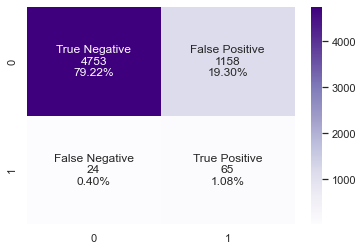

In [31]:
# make the thing 
rf = RandomForestClassifier(min_samples_leaf = 6, max_depth = 3)
# fit the thing
rf.fit(X_train, y_train)
# use the thing
pred = rf.predict(X_train)
accuracy_train = rf.score(X_train, y_train)
accuracy_validate = rf.score(X_validate, y_validate)
print("Accuracy of train:", '{:.2%}'.format(accuracy_train))
print("Accuracy of validate:", '{:.2%}'.format(accuracy_validate))

cf_matrix = confusion_matrix(pred, y_train)

group_names = ['True Negative','False Positive','False Negative','True Positive']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot = labels, fmt = '', cmap = 'Purples')
plt.show()

### Model 3: Logistic Regression

Accuracy of train: 79.62%
Accuracy of validate: 79.65%


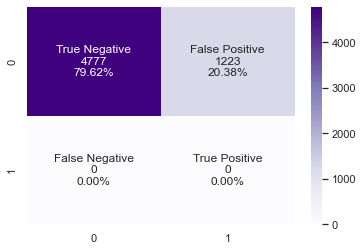

In [32]:
# make the thing 
logit = LogisticRegression() 
# fit the thing
logit.fit(X_train, y_train)
# use the thing
pred = logit.predict(X_train)

accuracy_train = logit.score(X_train, y_train)
accuracy_validate = logit.score(X_validate, y_validate)
print("Accuracy of train:", '{:.2%}'.format(accuracy_train))
print("Accuracy of validate:", '{:.2%}'.format(accuracy_validate))


cf_matrix = confusion_matrix(pred, y_train)

group_names = ['True Negative','False Positive','False Negative','True Positive']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot = labels, fmt = '', cmap = 'Purples')
plt.show()

## TEST Models

In [33]:
# Decision Tree model has the best accuracy of 80.43%, let's do a test on it
print('Accuracy of Decision Tree Classifier on test set: {:.2f}'
        .format(clf.score(X_test, y_test)))

Accuracy of Decision Tree Classifier on test set: 0.81


## Takeaways

 -To address our exploratory question:
 
 -Which is the best method to predict customer churn?

- When we run the test data, the accuracy for Decision Tree model train is maintained at 81%. Therefore, the model has no data overfit.
-  The best model is DecisionTreeClassifier at depth(4)
- Decision Tree Classifier perform the best with an accuracy of 81% performing 2 percent better than the baseline's 79%.

## Conclusion/Recommendations/Next Steps

### Conclusion:
- Customer churn prediction is important to a long-term financial stability of banks. In this project, I successfully created a machine learning model - Decision Tree Classifier that was able to predict customer churn with an accuracy of 81% performing 2 percent better than the baseline's 79%.

- We can conclude that of all the feature age, country, gender and balance had a impact on customer churn.
- Age: Customers at age 30-40 considered as the young are more likely to churn than oder ones, it is also this age bracket that has less than 600 credit score.
- Country: Germany has the highest churn rate compared to other countries Spain and France.
- Gender: Female customers are easier to churn than male customers.
- Balance: Customers with high balances are more likely to churn.

### Recommendations:
- Age: We can see that younger customers are more likely to leave a bank because they are uneducated on building good credit and wealth. Banks should come up with loyalty and retention programs aimed at customers who can still be saved especially customers with poor credit scores given their age, or anyone with a credit score below 600.
- Gender: Since banks are losing more female customers, they need to allocate more resources into pursuing female-oriented promotions such as offering rewards cards and points. Our data evidently shows female are likely to leave because they are bigger spenders and will tend to spend a lot to keep their lifestyles. 


### Next Steps:

- My next step would be to find out how much did our y variable change over the period of 2 years to acquire the right information to do another research.
- I would also like to do a research on Country - Germany and find out why it has the highest churn compared to the rest. Is it because of policies? Do banks have heavy competition?
- I would recommend that in the future we research on age and find out why middle age adult are leaving and find ways to retain them.
- Finally, I would love to check if my recommendations had an impact on our future data.